In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive',force_remount=True)

In [2]:
# !unzip -q "/content/gdrive/My Drive/INTC_2015-01-01_2015-01-31_10.zip" -d "/content/gdrive/My Drive/thesis/data/"

In [3]:
import glob
import json
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore
from tensorflow import keras

/Users/tanvi/pyenvs/lob/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tanvi/pyenvs/lob/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tanvi/pyenvs/lob/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tanvi/pyenvs/lob/lib/python3.7/site-packages/tensorflow/python/framework

In [4]:
# Constants
# batch size for model
BATCH_SIZE = 128

# number of epochs
EPOCHS = 100

# learning rate and epsilon for ADAM optimizer
LEARNING_RATE = 0.01
EPSILON = 1

# path where data is stored
stock = "INTC"
STOCK_PATH = "{}_2015-01-01_2015-01-31_10".format(stock)
DATA_PATH = "/Users/tanvi/projects/thesis/data/"
PATH = DATA_PATH+STOCK_PATH

# bool flag to decide if data needs to be written
write_data = True

In [5]:
# Static objects
# instantiate one hot encoder here so that all classes will always map to the same labels
onehot_encoder = OneHotEncoder(sparse=False)

# column names
levels = 10
nums = map(str, range(1,levels+1))
col_names = [y + x for x in nums for y in ['ask_price_', 'ask_size_', 'bid_price_', 'bid_size_']]

# first 10 days are used to train, 6 for val and 4 for test (TSLA and INTC each have 20 working days of data)
days = list(range(20))
train_days = days[:10]
val_days = days[10:16]
test_days = days[16:20]

## Preprocess the data

In [6]:
all_files = glob.glob(PATH + "/*orderbook_10.csv")
all_files.sort()
print("Number of files:",len(all_files))

def read_data(days, data_type):
    dfs = []
    print("Reading {}".format(data_type))
    for filename in [all_files[i] for i in days]:
        df = pd.read_csv(filename, index_col=None, header=None, names=col_names)
        dfs.append(df)
    data = pd.concat(dfs, axis=0, ignore_index=True)
    return data

Number of files: 20


In [7]:
def filter_data(data):
    # filter out all data points where the midprice remains unchanged
    normalised_data = data.apply(zscore)
    normalised_data['midprice'] = (normalised_data.ask_price_1+normalised_data.bid_price_1)/2
    normalised_data['change'] = normalised_data.midprice - normalised_data.midprice.shift()
    filtered_data = normalised_data[normalised_data.change!=0]
    filtered_data['label'] = np.where(filtered_data.change > 0, 'up', 'down')
    return filtered_data

In [8]:
def reshape_and_categorise_data(data):    
    # reshape input data into the shape of (batches, 1, 40, 1) as one input has 100 timesteps with 40 features
    input_data = data[col_names]
    input_array = input_data.to_numpy().reshape(len(input_data), 1, 40, 1)
    output_data = data.label.to_numpy()
    # encode labels to vectors
    integer_encoded = output_data.reshape(len(output_data), 1)
    output_array = onehot_encoder.fit_transform(integer_encoded)
    return input_array, output_array

In [9]:
# data normalisation, smoothing and labelling
def preprocess_data(data, data_type):
    data = filter_data(data)
    X, y = reshape_and_categorise_data(data)
    print("{} input shape:".format(data_type), X.shape)
    print("{} output shape:".format(data_type), y.shape)
    return X, y

In [10]:
train_data = read_data(train_days, data_type="Training")
X_train, y_train = preprocess_data(train_data, data_type="Training")

Reading Training


/Users/tanvi/pyenvs/lob/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Training input shape: (98041, 1, 40, 1)
Training output shape: (98041, 2)


In [12]:
train_data.apply(zscore)

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
0,0.765692,-0.109104,0.341303,-0.878711,0.787072,-1.195593,0.277127,-1.170606,0.851240,-1.192472,...,-0.236294,-0.813020,1.792322,-0.515894,-0.279050,-0.863452,1.877830,-0.203598,-0.407366,-0.777121
1,0.765692,-0.109104,0.341303,-0.878711,0.787072,-1.195593,0.277127,-1.170606,0.851240,-1.192472,...,-0.236294,-0.813020,1.792322,-0.515894,-0.279050,-0.863452,1.877830,-0.203598,-0.407366,-0.777121
2,0.765692,-0.109104,0.341303,-0.946859,0.787072,-1.195593,0.277127,-1.170606,0.851240,-1.192472,...,-0.236294,-0.813020,1.792322,-0.515894,-0.279050,-0.863452,1.877830,-0.203598,-0.407366,-0.777121
3,0.765692,-0.109104,0.341303,-0.946859,0.787072,-1.195593,0.277127,-1.170606,0.851240,-1.192472,...,-0.000954,-0.813020,1.792322,-0.515894,-0.214868,-0.863452,1.877830,-0.203598,-0.257616,-0.777121
4,0.765692,-0.109104,0.341303,-0.946859,0.787072,-1.195593,0.277127,-1.170606,0.851240,-1.192472,...,-0.000954,-0.813020,1.792322,-0.515894,-0.214868,-0.863452,1.877830,-0.203598,-0.257616,-0.777121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945760,-0.368096,1.584460,-0.364729,4.433236,-0.368107,-1.195593,-0.364720,-1.087028,-0.368113,0.437258,...,-0.364660,0.429321,-0.368163,-0.515894,-0.364625,1.284046,-0.368179,0.134709,-0.364580,-0.421780
9945761,-0.368096,1.584460,-0.364729,4.433236,-0.368107,-1.195593,-0.364720,-1.087028,-0.368113,0.437258,...,-0.364660,0.429321,-0.368163,-0.515894,-0.364625,1.345403,-0.368179,0.134709,-0.364580,-0.421780
9945762,-0.368096,1.584460,-0.364729,4.433236,-0.368107,-1.195593,-0.364720,-1.087028,-0.368113,0.437258,...,-0.364660,0.429321,-0.368163,-0.515894,-0.364625,1.386307,-0.368179,0.134709,-0.364580,-0.421780
9945763,-0.368096,2.291093,-0.364729,4.433236,-0.368107,-1.195593,-0.364720,-1.087028,-0.368113,0.437258,...,-0.364660,0.429321,-0.368163,-0.515894,-0.364625,1.386307,-0.368179,0.134709,-0.364580,-0.421780


In [56]:
# if write_data:
train_data = read_data(train_days, data_type="Training")
test_data = read_data(test_days, data_type="Validation")
val_data = read_data(val_days, data_type="Test")

X_train, y_train = preprocess_data(train_data, data_type="Training")
X_val, y_val = preprocess_data(val_data, data_type="Validation")
X_test, y_test = preprocess_data(test_data, data_type="Test")

# np.save(file="{}{}_X_train.npy".format(DATA_PATH, stock), arr=X_train)
# np.save(file="{}{}_y_train.npy".format(DATA_PATH, stock), arr=y_train)
# np.save(file="{}{}_X_val.npy".format(DATA_PATH, stock), arr=X_val)
# np.save(file="{}{}_y_val.npy".format(DATA_PATH, stock), arr=y_val)
# np.save(file="{}{}_X_test.npy".format(DATA_PATH, stock), arr=X_test)
# np.save(file="{}{}_y_test.npy".format(DATA_PATH, stock), arr=y_test)
# print("All data written to file.")
# else:
#     X_train = np.load("{}{}_X_train.npy".format(DATA_PATH, stock))
#     print("Training input shape:", X_train.shape)
#     y_train = np.load("{}{}_y_train.npy".format(DATA_PATH, stock))
#     print("Training output shape:", y_train.shape)
#     X_val = np.load("{}{}_X_val.npy".format(DATA_PATH, stock))
#     print("Validation input shape:", X_val.shape)
#     y_val = np.load("{}{}_y_val.npy".format(DATA_PATH, stock))
#     print("Validation output shape:", y_val.shape)
#     X_test = np.load("{}{}_X_test.npy".format(DATA_PATH, stock))
#     print("Test input shape:", X_test.shape)
#     y_test = np.load("{}{}_y_test.npy".format(DATA_PATH, stock))
#     print("Test output shape:", y_test.shape)
#     print("All data loaded.")

Reading Training
Reading Validation
Reading Test


/Users/tanvi/pyenvs/lob/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Training input shape: (98041, 1, 40, 1)
Training output shape: (98041, 2)


TypeError: preprocess_data() got an unexpected keyword argument 'k'

In [62]:
encodings = [[1,0],[0,1]]
mapping = {str(np.argmax(key)):onehot_encoder.inverse_transform([key]).tolist()[0][0] for key in encodings}
mapping

{'0': 'down', '1': 'up'}

### Build and compile the model

In [45]:
def create_model():
    # convolutional layers
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,2), input_shape=(1,40,1), strides=(1, 2)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,1)))
    
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,2), strides=(1, 2)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,1)))
    
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,10), input_shape=(1,10,1)))
    model.add(keras.layers.LeakyReLU(alpha=0.01))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,1)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(1,1)))
    
    model.add(keras.layers.MaxPooling2D(pool_size=(1,1)))
    model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))

    # lstm layer
    model.add(keras.layers.LSTM(100,kernel_regularizer=keras.regularizers.l2(0.01),return_sequences=False))
    model.add(keras.layers.Dropout(0.50))
    model.add(keras.layers.Dense(2,activation='softmax'))

    # compile model and summarize
    adam = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=1)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
model = create_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 20, 16)         48        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 20, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 20, 16)         272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 20, 16)         272       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 10, 16)         528       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 10, 16)         0         
____

In [0]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
print("Batch size:{}, Prediction horizon(K):{}, Learning Rate:{}".format(BATCH_SIZE, K, LEARNING_RATE))
csv_logger = keras.callbacks.CSVLogger('/content/gdrive/My Drive/thesis/101-tanh.csv', append=True, separator=',')
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[csv_logger], 
                    validation_data=(X_val, y_val), verbose=1)
score, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Accuracy is {}%".format(accuracy*100))

Batch size:128, Prediction horizon(K):50, Learning Rate:0.01
Train on 99456 samples, validate on 48626 samples
Epoch 1/100
99456/99456 [==============================] - 269s 3ms/sample - loss: 1.3201 - acc: 0.5246 - val_loss: 1.2855 - val_acc: 0.5062
Epoch 2/100
99456/99456 [==============================] - 269s 3ms/sample - loss: 1.2286 - acc: 0.5392 - val_loss: 1.1686 - val_acc: 0.5521
Epoch 3/100
99456/99456 [==============================] - 268s 3ms/sample - loss: 1.1583 - acc: 0.5502 - val_loss: 1.1059 - val_acc: 0.5544
Epoch 4/100
99456/99456 [==============================] - 268s 3ms/sample - loss: 1.0975 - acc: 0.5502 - val_loss: 1.0525 - val_acc: 0.5531
Epoch 5/100
99456/99456 [==============================] - 269s 3ms/sample - loss: 1.0463 - acc: 0.5501 - val_loss: 1.0146 - val_acc: 0.5539
Epoch 6/100
99456/99456 [==============================] - 269s 3ms/sample - loss: 1.0102 - acc: 0.5537 - val_loss: 0.9935 - val_acc: 0.5534
Epoch 7/100
99456/99456 [==================

### Evaluate performance

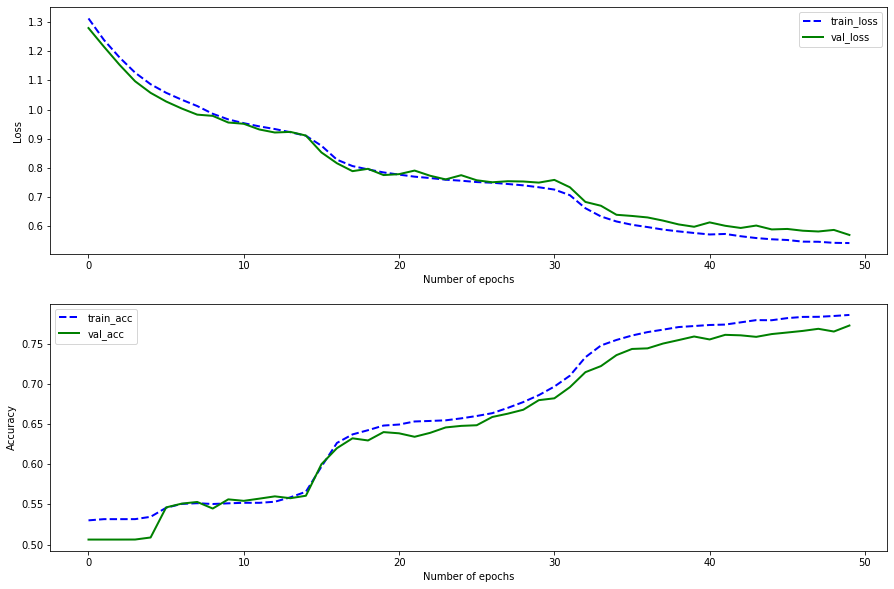

In [0]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
plt.legend()
# plt.ylim([.2,1.0])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

In [0]:
target_names = [mapping[str(i)] for i in range(3)]
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2])
print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))

              precision    recall  f1-score   support

        down       0.62      0.69      0.66      8831
  stationary       0.74      0.79      0.77     17846
          up       0.73      0.59      0.65     12070

    accuracy                           0.71     38747
   macro avg       0.70      0.69      0.69     38747
weighted avg       0.71      0.71      0.71     38747

[[ 6131  1939  1769]
 [ 1820 14162  3193]
 [  880  1745  7108]]


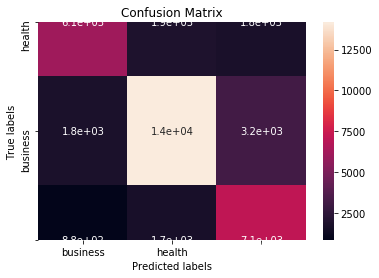

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['down', 'stationary', 'up']); ax.yaxis.set_ticklabels(['down', 'stationary', 'up']);

In [0]:
type(cm)

numpy.ndarray